In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from bcnn_gal_171022 import *
import nn_shson
from shson_exp_manager import *
import h5py
import random

%matplotlib inline


In [2]:
def num_to_onehot(nums, n_labels):
    results = list()
    for i in range(len(nums)):
        res = np.zeros([n_labels])
        res[nums[i]] = 1
        results.append(res)
    return np.asarray(results, dtype = 'float32')
        

In [3]:
mnist = h5py.File('mnist.hdf5', 'r')

random.seed(1337)

perm1 = range(784)
perm2 = range(784)
perm3 = range(784)
perm4 = range(784)
perm5 = range(784)
perm6 = range(784)

random.shuffle(perm1)
random.shuffle(perm2)
random.shuffle(perm3)
random.shuffle(perm4)
random.shuffle(perm5)
random.shuffle(perm6)

print perm1[0:20]
print perm2[0:20]

x_train = list()
x_valid = list()
x_test = list()

x_train.append(mnist['train_data'][()])
x_train.append(mnist['train_data'][()][:, perm1])
x_train.append(mnist['train_data'][()][:, perm2])
x_train.append(mnist['train_data'][()][:, perm3])
x_train.append(mnist['train_data'][()][:, perm4])
x_train.append(mnist['train_data'][()][:, perm5])
x_train.append(mnist['train_data'][()][:, perm6])
t_train = num_to_onehot(mnist['train_label'][()], 10)
x_valid.append(mnist['valid_data'][()])
x_valid.append(mnist['valid_data'][()][:, perm1])
x_valid.append(mnist['valid_data'][()][:, perm2])
x_valid.append(mnist['valid_data'][()][:, perm3])
x_valid.append(mnist['valid_data'][()][:, perm4])
x_valid.append(mnist['valid_data'][()][:, perm5])
x_valid.append(mnist['valid_data'][()][:, perm6])
t_valid = num_to_onehot(mnist['valid_label'][()], 10)
x_test.append(mnist['test_data'][()])
x_test.append(mnist['test_data'][()][:, perm1])
x_test.append(mnist['test_data'][()][:, perm2])
x_test.append(mnist['test_data'][()][:, perm3])
x_test.append(mnist['test_data'][()][:, perm4])
x_test.append(mnist['test_data'][()][:, perm5])
x_test.append(mnist['test_data'][()][:, perm6])
t_test = num_to_onehot(mnist['test_label'][()], 10)

mnist.close()


[290, 476, 531, 412, 667, 470, 656, 123, 167, 378, 357, 729, 324, 327, 271, 681, 155, 75, 755, 316]
[398, 598, 337, 481, 192, 554, 297, 296, 157, 72, 29, 778, 513, 407, 264, 420, 69, 508, 690, 504]


In [4]:
batch_size = 200

In [5]:
def print_accs(accs, ep):
    res = ""
    for acc in accs:
        res += " {:.4f}".format(acc[ep])
    
    print res

# Gal's BCNN

In [6]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [7]:
bcnn_gal = bcnn_gal_model([28, 28, 1], [[5, 5, 1, 32],[3, 3, 32, 64]], [True, True], [7 * 7 * 64, 100, 10], w_stdev = 0.1, n_samples = 10, \
                outact = tf.nn.relu, lr = 1e-3, l2_reg = False, l2_lambda = 0.1)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves_bcnn_gal/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')


conv layer done
conv layer done
fc layer done
fc layer done
(?, 10)


## Without Dropout

In [8]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 500
n_batches = len(t_train) / batch_size
patience = 3

taccs_bcnn_gal = list()
#taccs_mean = list()
vaccs_bcnn_gal = list()
epochs_done = list()
for i in range(n_datas):
    vaccs_bcnn_gal.append(list())
    
for d in range(n_datas):
    bcnn_gal.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):
        
        for i in range(n_batches):
            feed = {bcnn_gal.x: np.reshape(x_train[d][i*batch_size:(i+1)*batch_size], (-1, 28, 28, 1)), \
                    bcnn_gal.t: t_train[i*batch_size:(i+1)*batch_size], \
                    bcnn_gal.keep_probs: [1, 1, 1, 1]}

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = bcnn_gal.validate(feed)                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))

            bcnn_gal.train(feed)

        if ep > 5 and np.mean(taccs_bcnn_gal[-25:]) < taccs_bcnn_gal[-1]:
            if patience == 0:
                last_lr = bcnn_gal.get_lr()
                bcnn_gal.decay_lr()
                patience = 3

                if bcnn_gal.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    epochs_done.append(ep)
                    break
            else:
                patience -= 1
        if ep == (n_epochs) - 1: epochs_done.append(ep)
                
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            #vaccs_bcnn_gal[i].append(bcnn_gal.validate({bcnn_gal.x: np.reshape(x_valid[i], (-1, 28, 28, 1)), \
             #                                           bcnn_gal.t: t_valid, bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5]}))
            vaccs_bcnn_gal[i].append(bcnn_gal.validate({bcnn_gal.x: np.reshape(x_valid[i], (-1, 28, 28, 1)), \
                                                        bcnn_gal.t: t_valid, bcnn_gal.keep_probs: [1, 1, 1, 1]}))
            str_vacc += " {:.5g}".format(vaccs_bcnn_gal[i][-1])
        
        taccs_bcnn_gal.append(train_accuracy)
        
        print(str_vacc)

        #summary = sess.run(merged, feed_dict ={bcnn_gal.x: np.reshape(x_valid[d], (-1, 28, 28, 1)), \
        #                                       bcnn_gal.t: t_valid, bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5]})
        summary = sess.run(merged, feed_dict ={bcnn_gal.x: np.reshape(x_valid[d], (-1, 28, 28, 1)), \
                                               bcnn_gal.t: t_valid, bcnn_gal.keep_probs: [1, 1, 1, 1]})
        test_writer.add_summary(summary, (d+1)*(ep+1))
    




ep 0, batch 0, training accuracy 0.105
ep 0, batch 50, training accuracy 0.945
ep 0, batch 100, training accuracy 0.94
ep 0, batch 150, training accuracy 0.975
ep 0, batch 200, training accuracy 0.985
valid accuracy: 0.9386 0.1047 0.1017 0.1126 0.1218 0.1066 0.0658
valid accuracy: 0.9737 0.1005 0.1045 0.1031 0.1201 0.0946 0.0643
valid accuracy: 0.9765 0.0913 0.1005 0.099 0.1109 0.0928 0.0646
valid accuracy: 0.9701 0.0814 0.0984 0.0993 0.0989 0.0902 0.0721
valid accuracy: 0.9766 0.0818 0.1003 0.0993 0.105 0.0923 0.0715
valid accuracy: 0.9812 0.0826 0.1054 0.1043 0.1147 0.0989 0.0712
valid accuracy: 0.9851 0.0855 0.1109 0.1111 0.1228 0.111 0.074
valid accuracy: 0.9855 0.0837 0.106 0.1122 0.1296 0.1122 0.078
valid accuracy: 0.9871 0.0817 0.1038 0.115 0.1346 0.1101 0.0807
valid accuracy: 0.9877 0.0814 0.0985 0.1198 0.142 0.1143 0.0825
valid accuracy: 0.9874 0.0808 0.0995 0.1222 0.1377 0.1158 0.0855
valid accuracy: 0.9881 0.0796 0.0949 0.1217 0.1438 0.1231 0.086
valid accuracy: 0.9896 0.078

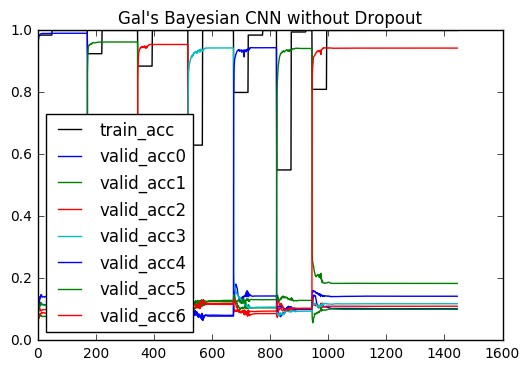

In [9]:
plt.title('Gal\'s Bayesian CNN without Dropout')
plt.plot(taccs_bcnn_gal, 'k')
plt.plot(vaccs_bcnn_gal[0], 'b')
plt.plot(vaccs_bcnn_gal[1], 'g')
plt.plot(vaccs_bcnn_gal[2], 'r')
plt.plot(vaccs_bcnn_gal[3], 'c')
plt.plot(vaccs_bcnn_gal[4], 'b')
plt.plot(vaccs_bcnn_gal[5], 'g')
plt.plot(vaccs_bcnn_gal[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

## Using Dropout

In [10]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 500
n_batches = len(t_train) / batch_size
patience = 3

taccs_bcnn_gal = list()
#taccs_mean = list()
vaccs_bcnn_gal = list()
epochs_done = list()

for i in range(n_datas):
    vaccs_bcnn_gal.append(list())
    
for d in range(n_datas):
    bcnn_gal.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):
        
        for i in range(n_batches):
            feed = {bcnn_gal.x: np.reshape(x_train[d][i*batch_size:(i+1)*batch_size], (-1, 28, 28, 1)), \
                    bcnn_gal.t: t_train[i*batch_size:(i+1)*batch_size], \
                    bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5]}

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = bcnn_gal.validate(feed)                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))

            bcnn_gal.train(feed)

        if ep > 5 and np.mean(taccs_bcnn_gal[-25:]) < taccs_bcnn_gal[-1]:
            if patience == 0:
                last_lr = bcnn_gal.get_lr()
                bcnn_gal.decay_lr()
                patience = 3

                if bcnn_gal.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    epochs_done.append(ep)
                    break
            else:
                patience -= 1
        if ep == (n_epochs) - 1: epochs_done.append(ep)
                
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            #vaccs_bcnn_gal[i].append(bcnn_gal.validate({bcnn_gal.x: np.reshape(x_valid[i], (-1, 28, 28, 1)), \
             #                                           bcnn_gal.t: t_valid, bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5]}))
            vaccs_bcnn_gal[i].append(bcnn_gal.validate({bcnn_gal.x: np.reshape(x_valid[i], (-1, 28, 28, 1)), \
                                                        bcnn_gal.t: t_valid, bcnn_gal.keep_probs: [1, 1, 1, 1]}))
            str_vacc += " {:.5g}".format(vaccs_bcnn_gal[i][-1])
        
        taccs_bcnn_gal.append(train_accuracy)
        
        print(str_vacc)

        #summary = sess.run(merged, feed_dict ={bcnn_gal.x: np.reshape(x_valid[d], (-1, 28, 28, 1)), \
        #                                       bcnn_gal.t: t_valid, bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5]})
        summary = sess.run(merged, feed_dict ={bcnn_gal.x: np.reshape(x_valid[d], (-1, 28, 28, 1)), \
                                               bcnn_gal.t: t_valid, bcnn_gal.keep_probs: [1, 1, 1, 1]})
        test_writer.add_summary(summary, (d+1)*(ep+1))




ep 0, batch 0, training accuracy 0.125
ep 0, batch 50, training accuracy 0.475
ep 0, batch 100, training accuracy 0.45
ep 0, batch 150, training accuracy 0.465
ep 0, batch 200, training accuracy 0.49
valid accuracy: 0.9381 0.1373 0.1242 0.0834 0.1132 0.098 0.0878
valid accuracy: 0.9563 0.1113 0.1059 0.0986 0.1087 0.0869 0.0893
valid accuracy: 0.9628 0.1081 0.1252 0.0747 0.1109 0.1113 0.087
valid accuracy: 0.9682 0.1041 0.1035 0.0995 0.1107 0.103 0.091
valid accuracy: 0.9737 0.1012 0.0927 0.093 0.1078 0.1011 0.0805
valid accuracy: 0.9765 0.1036 0.0988 0.0997 0.1045 0.1221 0.0789
valid accuracy: 0.9717 0.0952 0.1023 0.0989 0.1048 0.1131 0.0827
valid accuracy: 0.9755 0.0961 0.1014 0.0976 0.1122 0.1094 0.0795
valid accuracy: 0.9754 0.0934 0.101 0.0991 0.1148 0.1018 0.0933
valid accuracy: 0.9781 0.0925 0.0998 0.0929 0.1155 0.1171 0.0944
valid accuracy: 0.9796 0.0882 0.1042 0.0997 0.1027 0.1134 0.0942
valid accuracy: 0.9804 0.0949 0.1074 0.0983 0.1097 0.1122 0.0942
valid accuracy: 0.9821 0.0

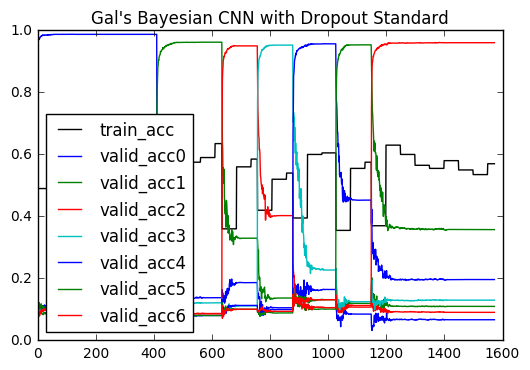

In [11]:
plt.title('Gal\'s Bayesian CNN with Dropout Standard')
plt.plot(taccs_bcnn_gal, 'k')
plt.plot(vaccs_bcnn_gal[0], 'b')
plt.plot(vaccs_bcnn_gal[1], 'g')
plt.plot(vaccs_bcnn_gal[2], 'r')
plt.plot(vaccs_bcnn_gal[3], 'c')
plt.plot(vaccs_bcnn_gal[4], 'b')
plt.plot(vaccs_bcnn_gal[5], 'g')
plt.plot(vaccs_bcnn_gal[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

## Using Dropout(MC Dropout with sample 1)

In [12]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 500
n_batches = len(t_train) / batch_size
patience = 3

taccs_bcnn_gal = list()
#taccs_mean = list()
vaccs_bcnn_gal = list()
epochs_done = list()

for i in range(n_datas):
    vaccs_bcnn_gal.append(list())
    
for d in range(n_datas):
    bcnn_gal.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):
        
        for i in range(n_batches):
            feed = {bcnn_gal.x: np.reshape(x_train[d][i*batch_size:(i+1)*batch_size], (-1, 28, 28, 1)), \
                    bcnn_gal.t: t_train[i*batch_size:(i+1)*batch_size], \
                    bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5]}

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = bcnn_gal.validate(feed)                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))

            bcnn_gal.train(feed)

        if ep > 5 and np.mean(taccs_bcnn_gal[-25:]) < taccs_bcnn_gal[-1]:
            if patience == 0:
                last_lr = bcnn_gal.get_lr()
                bcnn_gal.decay_lr()
                patience = 3

                if bcnn_gal.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    epochs_done.append(ep)
                    break
            else:
                patience -= 1
        if ep == (n_epochs) - 1: epochs_done.append(ep)
                
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs_bcnn_gal[i].append(bcnn_gal.validate({bcnn_gal.x: np.reshape(x_valid[i], (-1, 28, 28, 1)), \
                                                       bcnn_gal.t: t_valid, bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5]}))
            #vaccs_bcnn_gal[i].append(bcnn_gal.validate({bcnn_gal.x: np.reshape(x_valid[i], (-1, 28, 28, 1)), \
            #                                            bcnn_gal.t: t_valid, bcnn_gal.keep_probs: [1, 1, 1, 1]}))
            str_vacc += " {:.5g}".format(vaccs_bcnn_gal[i][-1])
        
        taccs_bcnn_gal.append(train_accuracy)
        
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={bcnn_gal.x: np.reshape(x_valid[d], (-1, 28, 28, 1)), \
                                              bcnn_gal.t: t_valid, bcnn_gal.keep_probs: [0.5, 0.5, 0.5, 0.5]})
#         summary = sess.run(merged, feed_dict ={bcnn_gal.x: np.reshape(x_valid[d], (-1, 28, 28, 1)), \
#                                                bcnn_gal.t: t_valid, bcnn_gal.keep_probs: [1, 1, 1, 1]})
        test_writer.add_summary(summary, (d+1)*(ep+1))




ep 0, batch 0, training accuracy 0.075
ep 0, batch 50, training accuracy 0.38
ep 0, batch 100, training accuracy 0.425
ep 0, batch 150, training accuracy 0.495
ep 0, batch 200, training accuracy 0.535
valid accuracy: 0.5344 0.0998 0.1122 0.0901 0.0938 0.1024 0.092
valid accuracy: 0.5515 0.0915 0.1115 0.1031 0.1061 0.1165 0.0875
valid accuracy: 0.5585 0.0954 0.0982 0.1048 0.0979 0.108 0.0907
valid accuracy: 0.5735 0.0986 0.1032 0.1024 0.0992 0.1076 0.0933
valid accuracy: 0.5687 0.095 0.0997 0.105 0.0966 0.1071 0.0898
valid accuracy: 0.573 0.0925 0.1061 0.1033 0.1011 0.1132 0.0907
valid accuracy: 0.5722 0.0926 0.1011 0.1051 0.0995 0.1089 0.0942
valid accuracy: 0.5722 0.0973 0.1064 0.1061 0.0937 0.1101 0.0887
valid accuracy: 0.5771 0.093 0.1026 0.1093 0.0992 0.1071 0.0827
valid accuracy: 0.5761 0.0979 0.1088 0.1082 0.0966 0.1069 0.0964
valid accuracy: 0.5748 0.0951 0.0994 0.1042 0.1039 0.1054 0.0958
valid accuracy: 0.5857 0.1021 0.1045 0.1052 0.1104 0.1053 0.0978
valid accuracy: 0.5762 0.

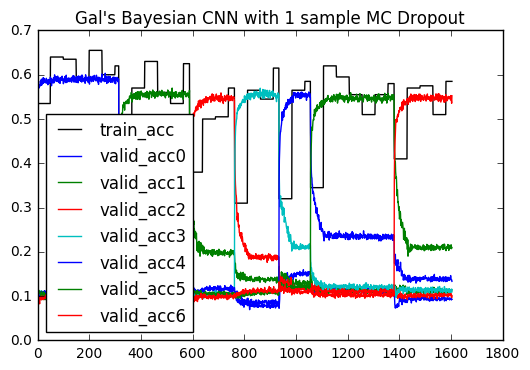

In [13]:
plt.title('Gal\'s Bayesian CNN with 1 sample MC Dropout')
plt.plot(taccs_bcnn_gal, 'k')
plt.plot(vaccs_bcnn_gal[0], 'b')
plt.plot(vaccs_bcnn_gal[1], 'g')
plt.plot(vaccs_bcnn_gal[2], 'r')
plt.plot(vaccs_bcnn_gal[3], 'c')
plt.plot(vaccs_bcnn_gal[4], 'b')
plt.plot(vaccs_bcnn_gal[5], 'g')
plt.plot(vaccs_bcnn_gal[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

# Blundell version

In [ ]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [ ]:
bnn = bnn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rhos = [-1.0, 5.0, 10.0], n_samples = 10, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, kl_reweight = True, train_rho = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

# train_writer = tf.train.SummaryWriter(savedir + 'train', sess.graph)
# test_writer = tf.train.SummaryWriter(savedir + 'test')

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')


In [ ]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 200
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())
    
for d in range(n_datas):
    bnn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):
        bnn.reset_klrw()

        for i in range(n_batches):
            
            bnn.decay_klrw()

            feed = {bnn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    bnn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
            fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = bnn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))
                
            bnn.train(feed)

        fs_mean.append(np.mean(fs[-n_batches:]))

        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = bnn.get_lr()
                bnn.decay_lr()
                patience = 3

                if bnn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1
                
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(bnn.validate({bnn.x: x_valid[i], bnn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={bnn.x: x_valid[d], bnn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))




In [ ]:
coeff_klrw = 1 / n_batches

plt.plot(fs, 'r')
plt.plot(qs*coeff_klrw, 'b')
plt.plot(ps*coeff_klrw, 'g')
plt.plot(ls, 'k')

# plt.plot(fs[0:22], 'r')
# plt.plot(qs[0:22], 'b')
# plt.plot(ps[0:22], 'g')
# plt.plot(ls[0:22], 'k')


plt.legend(['f', 'q', 'p', 'l'])
plt.show()

In [ ]:
plt.title('Blundell\'s Bayesian NN')
plt.plot(taccs, 'k')
plt.plot(vaccs[0], 'tab:blue')
plt.plot(vaccs[1], 'tab:orange')
plt.plot(vaccs[2], 'tab:green')
plt.plot(vaccs[3], 'tab:red')
plt.plot(vaccs[4], 'tab:purple')
plt.plot(vaccs[5], 'tab:brown')
plt.plot(vaccs[6], 'tab:pink')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

# Online version

In [ ]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [ ]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
bnn = bnn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rhos = [-5.0, 1.0, 10.0], n_samples = 10, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, kl_reweight = False, train_rho = True, only_loglike = False)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

In [ ]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 200
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())

for d in range(n_datas):
    bnn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {bnn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    bnn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
            fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)

            bnn.train(feed)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = bnn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = bnn.get_lr()
                bnn.decay_lr()
                patience = 3

                if bnn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1


        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(bnn.validate({bnn.x: x_valid[i], bnn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={bnn.x: x_valid[d], bnn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

    #     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
    #         bnn.decay_lr()

    bnn.update_prior()
    #bnn.print_params()




In [ ]:
plt.plot(fs, 'r')
plt.plot(qs, 'b')
plt.plot(ps, 'g')
plt.plot(ls, 'k')

# plt.plot(fs[0:22], 'r')
# plt.plot(qs[0:22], 'b')
# plt.plot(ps[0:22], 'g')
# plt.plot(ls[0:22], 'k')

plt.legend(['f', 'q', 'p', 'l'])
plt.show()

In [ ]:
taccs_BNN_OL = taccs
vaccs_BNN_OL = vaccs

plt.title('Bayesian NN')

plt.plot(taccs_BNN_OL, 'k')
plt.plot(vaccs_BNN_OL[0], 'b')
plt.plot(vaccs_BNN_OL[1], 'g')
plt.plot(vaccs_BNN_OL[2], 'r')
plt.plot(vaccs_BNN_OL[3], 'c')
plt.plot(vaccs_BNN_OL[4], 'b')
plt.plot(vaccs_BNN_OL[5], 'g')
plt.plot(vaccs_BNN_OL[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [ ]:
print_accs(vaccs_BNN_OL, 0)
print_accs(vaccs_BNN_OL, 199)
print_accs(vaccs_BNN_OL, 399)
print_accs(vaccs_BNN_OL, 599)
print_accs(vaccs_BNN_OL, 799)
print_accs(vaccs_BNN_OL, 999)
print_accs(vaccs_BNN_OL, 1199)
print_accs(vaccs_BNN_OL, 1399)

# Online version + EWC with rho_grad

In [ ]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [ ]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
bnn = bnn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rhos = [-5.0, 1.0, 10.0], n_samples = 10, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, kl_reweight = False, train_rho = True, only_loglike = False, ewc = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

In [ ]:
print bnn.p_params

In [ ]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 200
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())

for d in range(n_datas):
    bnn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {bnn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    bnn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
            fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)

            bnn.train(feed)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = bnn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = bnn.get_lr()
                bnn.decay_lr()
                patience = 3

                if bnn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1


        if ep % 50 == 0: bnn.print_ewcgrads(feed)
        
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(bnn.validate({bnn.x: x_valid[i], bnn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={bnn.x: x_valid[d], bnn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

    #     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
    #         bnn.decay_lr()

    bnn.update_prior()
    #bnn.print_params()




In [ ]:
plt.plot(fs, 'r')
plt.plot(qs, 'b')
plt.plot(ps, 'g')
plt.plot(ls, 'k')

# plt.plot(fs[0:22], 'r')
# plt.plot(qs[0:22], 'b')
# plt.plot(ps[0:22], 'g')
# plt.plot(ls[0:22], 'k')

plt.legend(['f', 'q', 'p', 'l'])
plt.show()

In [ ]:
taccs_BNN_MG = taccs
vaccs_BNN_MG = vaccs

plt.title('Bayesian NN with Modified Gradients')
plt.plot(taccs_BNN_MG, 'k')
plt.plot(vaccs_BNN_MG[0], 'b')
plt.plot(vaccs_BNN_MG[1], 'g')
plt.plot(vaccs_BNN_MG[2], 'r')
plt.plot(vaccs_BNN_MG[3], 'c')
plt.plot(vaccs_BNN_MG[4], 'b')
plt.plot(vaccs_BNN_MG[5], 'g')
plt.plot(vaccs_BNN_MG[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [ ]:
print_accs(vaccs_BNN_MG, 0)
print_accs(vaccs_BNN_MG, 199)
print_accs(vaccs_BNN_MG, 399)
print_accs(vaccs_BNN_MG, 599)
print_accs(vaccs_BNN_MG, 799)
print_accs(vaccs_BNN_MG, 999)
print_accs(vaccs_BNN_MG, 1199)
print_accs(vaccs_BNN_MG, 1399)

In [ ]:
taccs_BNN_MG = taccs
vaccs_BNN_MG = vaccs

plt.title('Bayesian NN with Modified Gradients')
plt.plot(taccs_BNN_MG, 'k')
plt.plot(vaccs_BNN_MG[0], 'b')
plt.plot(vaccs_BNN_MG[1], 'g')
plt.plot(vaccs_BNN_MG[2], 'r')
plt.plot(vaccs_BNN_MG[3], 'c')
plt.plot(vaccs_BNN_MG[4], 'b')
plt.plot(vaccs_BNN_MG[5], 'g')
plt.plot(vaccs_BNN_MG[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [ ]:
print_accs(vaccs_BNN_MG, 0)
print_accs(vaccs_BNN_MG, 199)
print_accs(vaccs_BNN_MG, 399)
print_accs(vaccs_BNN_MG, 599)
print_accs(vaccs_BNN_MG, 799)
print_accs(vaccs_BNN_MG, 999)
print_accs(vaccs_BNN_MG, 1199)
print_accs(vaccs_BNN_MG, 1399)

# Normal NN

In [ ]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [ ]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
nn = nn_shson.nn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, only_loglike = True, ewc = False)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

In [ ]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 2000
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())

for d in range(n_datas):
    nn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {nn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    nn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_l = nn.get_fqpl(feed)
            fs.append(v_f), ls.append(v_l)

            nn.train(feed)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = nn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                #print("f : {}, l : {}".format(v_f, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = nn.get_lr()
                nn.decay_lr()
                patience = 3

                if nn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1
        
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(nn.validate({nn.x: x_valid[i], nn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={nn.x: x_valid[d], nn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

    #     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
    #         bnn.decay_lr()

    nn.update_prior()
    #bnn.print_params()




In [ ]:
taccs_nNN = taccs
vaccs_nNN = vaccs

plt.title('Normal NN')

plt.plot(taccs_nNN, 'k')
plt.plot(vaccs_nNN[0], 'b')
plt.plot(vaccs_nNN[1], 'g')
plt.plot(vaccs_nNN[2], 'r')
plt.plot(vaccs_nNN[3], 'c')
plt.plot(vaccs_nNN[4], 'b')
plt.plot(vaccs_nNN[5], 'g')
plt.plot(vaccs_nNN[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [ ]:
print_accs(vaccs_nNN, 0)
print_accs(vaccs_nNN, 1999)
print_accs(vaccs_nNN, 3999)
print_accs(vaccs_nNN, 5999)
print_accs(vaccs_nNN, 7999)
print_accs(vaccs_nNN, 9999)
print_accs(vaccs_nNN, 11999)
print_accs(vaccs_nNN, 13999)

# Normal NN + EWC

In [ ]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [ ]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
enn = nn_shson.nn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, only_loglike = False, ewc = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

In [ ]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 2000
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())

for d in range(n_datas):
    enn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {enn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    enn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_l = enn.get_fqpl(feed)
            fs.append(v_f), ls.append(v_l)

            enn.train(feed)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = enn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                #print("f : {}, l : {}".format(v_f, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = enn.get_lr()
                enn.decay_lr()
                patience = 3

                if enn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1
        
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(enn.validate({enn.x: x_valid[i], enn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={enn.x: x_valid[d], enn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

    #     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
    #         bnn.decay_lr()

    enn.update_prior()
    #bnn.print_params()




In [ ]:
taccs_NNEWC = taccs
vaccs_NNEWC = vaccs

plt.title('Normal NN with EWC')
plt.plot(taccs_NNEWC, 'k')
plt.plot(vaccs_NNEWC[0], 'b')
plt.plot(vaccs_NNEWC[1], 'g')
plt.plot(vaccs_NNEWC[2], 'r')
plt.plot(vaccs_NNEWC[3], 'c')
plt.plot(vaccs_NNEWC[4], 'b')
plt.plot(vaccs_NNEWC[5], 'g')
plt.plot(vaccs_NNEWC[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [ ]:
print_accs(vaccs_NNEWC, 0)
print_accs(vaccs_NNEWC, 1999)
print_accs(vaccs_NNEWC, 3999)
print_accs(vaccs_NNEWC, 5999)
print_accs(vaccs_NNEWC, 7999)
print_accs(vaccs_NNEWC, 9999)
print_accs(vaccs_NNEWC, 11999)
print_accs(vaccs_NNEWC, 13999)

In [ ]:
taccs_NNEWC = taccs
vaccs_NNEWC = vaccs

plt.title('Normal NN with EWC')
plt.plot(taccs_NNEWC, 'k')
plt.plot(vaccs_NNEWC[0], 'b')
plt.plot(vaccs_NNEWC[1], 'g')
plt.plot(vaccs_NNEWC[2], 'r')
plt.plot(vaccs_NNEWC[3], 'c')
plt.plot(vaccs_NNEWC[4], 'b')
plt.plot(vaccs_NNEWC[5], 'g')
plt.plot(vaccs_NNEWC[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [ ]:
print_accs(vaccs_NNEWC, 0)
print_accs(vaccs_NNEWC, 1999)
print_accs(vaccs_NNEWC, 3999)
print_accs(vaccs_NNEWC, 5999)
print_accs(vaccs_NNEWC, 7999)
print_accs(vaccs_NNEWC, 9999)
print_accs(vaccs_NNEWC, 11999)
print_accs(vaccs_NNEWC, 13999)